# Goal

Find out who is the most important person in Tayvat (that is not the Traveler) with network centrality measures for version 4.7.

Changes in-game from version 4.6 to 4.7 (since data was updated):

* Clorinde's voicelines are added
* Sethos added as character and his voicelines are added
* Emillie and Sigewinnie confirmed to be playable characters

# 1. Data Processing

Prepare the data for analysis.

Import relevant libraries:

In [1]:
import os

import numpy as np
import pandas as pd

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

## 1.1 Read Data

Read data file from kaggle:

In [2]:
df = pd.read_csv('/kaggle/input/genshin-impact-voicelines/genshin_en_voicelines_v3.csv')

In [3]:
# preview dataframe
df.head(3)

,id,character,title,voice_line,requirements,about,nation
0,0,Kaveh,Hello,I'm glad you gave me a chance. I always think ...,NaN,NaN,Sumeru
1,1,Kaveh,Chat: Beauty,The ability to appreciate beauty is an importa...,NaN,NaN,Sumeru
2,2,Kaveh,Chat: Overcoming Boredom,It's good to get out and stretch your legs onc...,NaN,NaN,Sumeru


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3886 entries, 0 to 3885
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            3886 non-null   int64 
 1   character     3886 non-null   object
 2   title         3886 non-null   object
 3   voice_line    3886 non-null   object
 4   requirements  1800 non-null   object
 5   about         830 non-null    object
 6   nation        3854 non-null   object
dtypes: int64(1), object(6)
memory usage: 212.6+ KB


## 1.2 Process Data

Filter out Aloy's voicelines; Aloy will not be included in the analysis as she is a character that was added to the game for a collab and does not interact with any other playable characters in the game.

In [5]:
# ignore Aloy's voicelines
df = df[df['character'] != 'Aloy'].reset_index(drop=True)

Supplement `about` column

In [6]:
df[df['about']=='Alice']

,id,character,title,voice_line,requirements,about,nation
1134,1166,Dori,About Alice,Alice's range of eccentric novelties knows no ...,Friendship Lv. 4,Alice,Sumeru


In [7]:
df[(df['character']=='Albedo') & (df['title']=='About Family')]

,id,character,title,voice_line,requirements,about,nation
64,64,Albedo,About Family,Family? Although Alice has always asked me to ...,Friendship Lv. 6,NaN,Mondstadt


🔼 Notice above that while 'Alice' (Klee's mum) is only reflected in the 'about' column for Dori (extracted from the title being 'About Alice'), other people who are likely to mention Alice such as Albedo (who Alice adopted) do not have her in the 'about' column.

To add a little more information to the network graph, the 'about' column will be supplemented by extracting characters from the 'voice_line' column.

In [8]:
# get list of characters to check for 
about_characters = [i for i in list(df['about'].unique()) if i is not np.nan]

Supporting functions

In [9]:
# supplement 'about' column
def get_characters_from_voiceline(voiceline):
    '''checks voicelines for any characters that might have been missed'''
    noted_characters = []
    for chara in about_characters:
        if chara in voiceline: noted_characters.append(chara)
    return noted_characters

def add_about(row):
    '''combine characters in the 'about' column and any additional characters detected in the voice line itself'''
    all_about = row['about']
    additional_about = get_characters_from_voiceline(row['voice_line'])
    all_about.extend(additional_about)
    if '' in all_about: all_about.remove('') # remove any empty strings
    if row['character'] in all_about: all_about.remove(row['character'])    # prevent character from being in their own 'about' column
    if all_about: row['about'] = [a.strip() for a in list(set(all_about))]
    return row

In [10]:
# split the string in the about column to make a list
df['about'] = df['about'].apply(lambda x: x.split(';') if x is not np.nan else [])

In [11]:
# apply add_about function
df = df.apply(lambda r: add_about(r), axis=1)

In [12]:
# separate each list element in 'about' column to be its own row
df = df.explode('about').reset_index(drop=True)

In [13]:
# check number of rows with non-empty 'about' column
df[df['about'].notnull()].info()

<class 'pandas.core.frame.DataFrame'>
Index: 964 entries, 20 to 3916
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            964 non-null    int64 
 1   character     964 non-null    object
 2   title         964 non-null    object
 3   voice_line    964 non-null    object
 4   requirements  916 non-null    object
 5   about         964 non-null    object
 6   nation        964 non-null    object
dtypes: int64(1), object(6)
memory usage: 60.2+ KB


In [14]:
# check that there are more characters mentioning Alice
df[df['about']=='Alice']

,id,character,title,voice_line,requirements,about,nation
67,64,Albedo,About Family,Family? Although Alice has always asked me to ...,Friendship Lv. 6,Alice,Mondstadt
71,68,Albedo,About Klee,"Indeed, I view Klee as my younger sister. When...",Friendship Lv. 4,Alice,Mondstadt
928,934,Barbara,More About Barbara: III,"Being an idol, I learned from Alice that ""A tr...",Friendship Lv. 4,Alice,Mondstadt
1163,1166,Dori,About Alice,Alice's range of eccentric novelties knows no ...,Friendship Lv. 4,Alice,Sumeru
3437,3399,Mona,About Klee,"Ah yes, Alice's daughter. She's in the custody...",Friendship Lv. 4,Alice,Mondstadt


## 1.3 Create Edgelist

In [15]:
# create edgelist with weight 
edges = df[~df.about.isna()][['character', 'about', 'title', 'nation']].groupby(by=['character',  'about', 'nation']).count().reset_index()

# rename columns
edges.rename(columns={'character': 'source', 'about': 'target', 'title': 'weight'}, inplace=True)

In [16]:
# display top 10 edges by weight
edges.sort_values(by='weight', ascending=False).head(10)

,source,target,nation,weight
421,Lynette,Lyney,Fontaine,9
431,Lyney,Lynette,Fontaine,9
142,Collei,Amber,Sumeru,6
20,Amber,Jean,Mondstadt,6
228,Freminet,Lyney,Fontaine,6
744,Yaoyao,Xiangling,Liyue,6
369,Klee,Jean,Mondstadt,5
598,Tartaglia,Tsaritsa,Snezhnaya,4
380,Kujou Sara,Raiden Shogun,Inazuma,4
615,Tighnari,Collei,Sumeru,4


# 2. Directed Graph

## 2.1 Build Directed Graph

Reference mappings:

In [17]:
# mapping for nation to colours for node display
NATION_COLOUR_MAPPING = {
    'Mondstadt': '#74f3dd',
    'Liyue': '#ebc027',
    'Inazuma': '#b863cb',
    'Sumeru': '#7efd83',
    'Fontaine': '#009dff',
    'Snezhnaya': '#80e3fe'
}

In [18]:
NATION_MAP = {
    'Jean': 'Mondstadt',
    'Raiden Shogun': 'Inazuma',
    'Yanfei': 'Liyue',
    'Alhaitham': 'Sumeru',
    'Mona': 'Mondstadt',
    'Wriothesley': 'Fontaine',
    'Kaeya': 'Mondstadt',
    'Kuki Shinobu': 'Inazuma',
    'Yaoyao': 'Liyue',
    'Xiao': 'Liyue',
    'Tartaglia': 'Snezhnaya',
    'Sayu': 'Inazuma',
    'Layla': 'Sumeru',
    'Razor': 'Mondstadt',
    'Candace': 'Sumeru',
    'Yun Jin': 'Liyue',
    'Mika': 'Mondstadt',
    'Gorou': 'Inazuma',
    'Lisa': 'Mondstadt',
    'Freminet': 'Fontaine',
    'Sangonomiya Kokomi': 'Inazuma',
    'Xinyan': 'Liyue',
    'Charlotte': 'Fontaine',
    'Kaedehara Kazuha': 'Inazuma',
    'Arlecchino': 'Fontaine',
    'Baizhu': 'Liyue',
    'Diona': 'Mondstadt',
    'Noelle': 'Mondstadt',
    'Navia': 'Fontaine',
    'Cyno': 'Sumeru',
    'Nilou': 'Sumeru',
    'Yoimiya': 'Inazuma',
    'Gaming': 'Liyue',
    'Yae Miko': 'Inazuma',
    'Ganyu': 'Liyue',
    'Fischl': 'Mondstadt',
    'Shikanoin Heizou': 'Inazuma',
    'Zhongli': 'Liyue',
    'Beidou': 'Liyue',
    'Sucrose': 'Mondstadt',
    'Xingqiu': 'Liyue',
    'Yelan': 'Liyue',
    'Eula': 'Mondstadt',
    'Wanderer': 'Sumeru',
    'Kamisato Ayaka': 'Inazuma',
    'Lynette': 'Fontaine',
    'Keqing': 'Liyue',
    'Kujou Sara': 'Inazuma',
    'Bennett': 'Mondstadt',
    'Dehya': 'Sumeru',
    'Xiangling': 'Liyue',
    'Diluc': 'Mondstadt',
    'Nahida': 'Sumeru',
    'Qiqi': 'Liyue',
    'Chiori': 'Fontaine',
    'Tighnari': 'Sumeru',
    'Neuvillette': 'Fontaine',
    'Chevreuse': 'Fontaine',
    'Ningguang': 'Liyue',
    'Klee': 'Mondstadt',
    'Lyney': 'Fontaine',
    'Xianyun': 'Liyue',
    'Venti': 'Mondstadt',
    'Shenhe': 'Liyue',
    'Kirara': 'Inazuma',
    'Thoma': 'Inazuma',
    'Hu Tao': 'Liyue',
    'Kaveh': 'Sumeru',
    'Albedo': 'Mondstadt',
    'Dori': 'Sumeru',
    'Rosaria': 'Mondstadt',
    'Faruzan': 'Sumeru',
    'Chongyun': 'Liyue',
    'Barbara': 'Mondstadt',
    'Amber': 'Mondstadt',
    'Furina': 'Fontaine',
    'Arataki Itto': 'Inazuma',
    'Collei': 'Sumeru',
    'Kamisato Ayato': 'Inazuma',
    'Aloy': 'NA',
    'Traveler': 'NA',
    'Clorinde': 'Fontaine', 
    'Sigewinne': 'Fontaine',
    'Sethos': 'Sumeru',
    # tbd
    'Emilie': 'Fontaine',
    'Pierro': 'Snezhnaya',
    'Il Capitano': 'Snezhnaya',
    'Il Dottore': 'Snezhnaya',
    'Columbina': 'Snezhnaya',
    'Pulcinella': 'Snezhnaya',
    'Sandrone': 'Snezhnaya',
    'Pantalone': 'Snezhnaya',
    'Varka': 'Mondstadt',         
    'Tsaritsa': 'Snezhnaya',
    'Alice': 'Mondstadt',  
    'Moon Carver': 'Liyue',
    'Madame Ping': 'Liyue'
}

In [19]:
# build directed graph
DG = nx.from_pandas_edgelist(edges,
                            source='source',
                            target='target',
                            edge_attr='weight',
                            create_using=nx.DiGraph()
                            )
str(DG)

'DiGraph with 94 nodes and 787 edges'

In [20]:
# set 'nation' attribute for nodes
nx.set_node_attributes(DG, NATION_MAP, name='nation')

Assign a colour to each node based on their nation attribute

In [21]:
node_colors = []
for node, nation in list(DG.nodes(data="nation")):
    if nation in NATION_COLOUR_MAPPING.keys():
        node_colors.append(NATION_COLOUR_MAPPING[nation])
    else:
        node_colors.append('#b8b8b8') # doesn't belong to any nation / character's traits are not confirmed yet

Draw directed graph

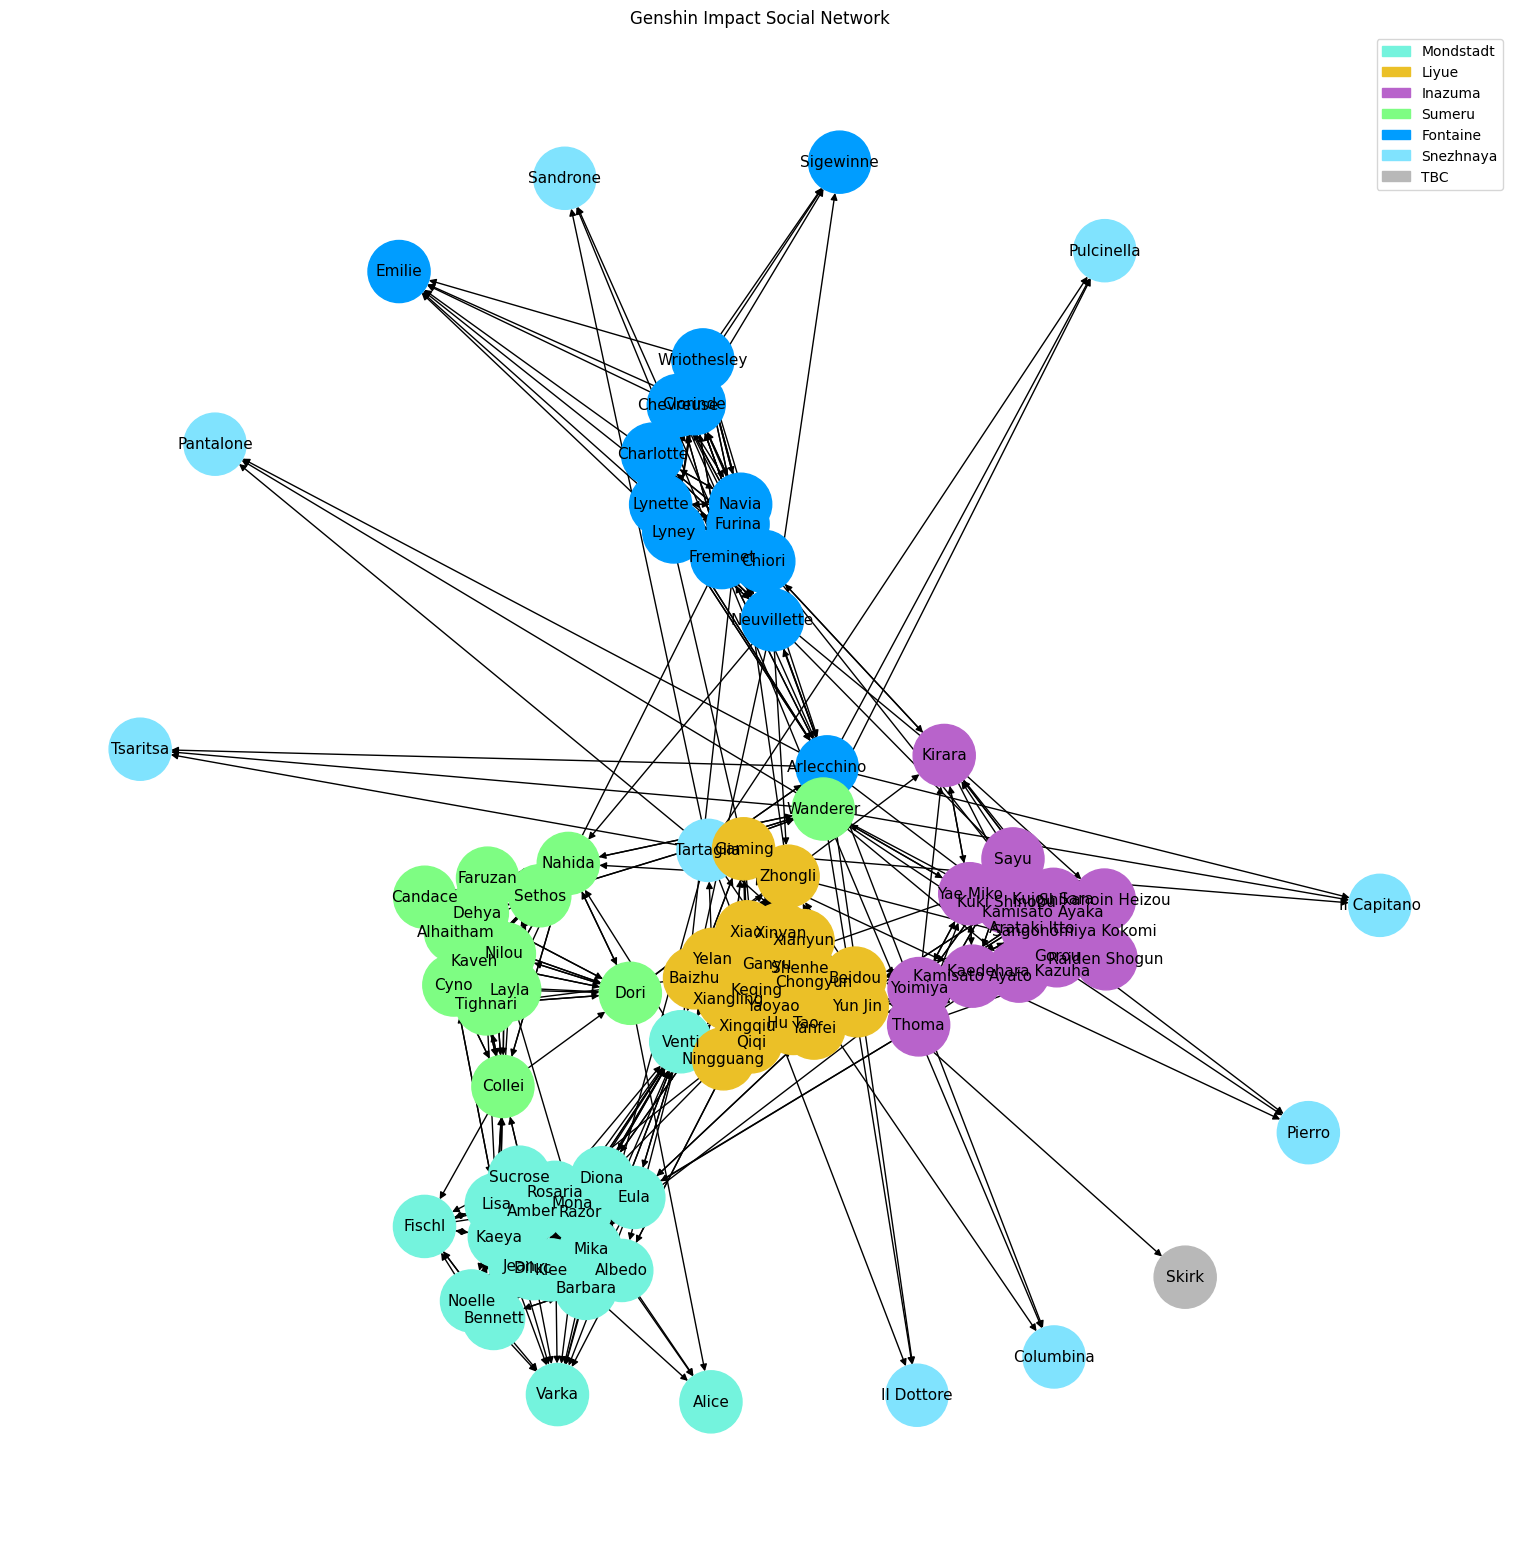

In [22]:
np.random.seed(2000)    # to keep diagram generated fixed o
pos = nx.spring_layout(DG, k=1.25, iterations=250)

plt.figure(1,figsize=(15,15)) 
nx.draw(DG,
        pos = pos,
        node_size=2000,
        node_color=node_colors,
        with_labels=True,
        font_size = 11,
        font_color='black')

# create legend
legend_tiles = [mpatches.Patch(color=v, label=k) for k, v in NATION_COLOUR_MAPPING.items()]
legend_tiles.append(mpatches.Patch(color="#b8b8b8", label="TBC"))

plt.title("Genshin Impact Social Network")
plt.legend(handles=legend_tiles, loc="upper right")
plt.show()

# uncomment to save picture
# plt.savefig('directed_graph.png')

<u>Directed Network Observations</u>
* There are a number of mentions that are not reciprocated (one-way):
  * e.g. Chiori → Shikanoin Heizou but there does not exist a tie going the other way, suggesting that Chiori mentions and hence is implied to know Heizou but Heizou does not know Chiori. Similarly for Layla → Dori.
  * This lack of reciprocity might be due to some characters not being released yet and thus not having voiceline data
  * The only way to know anything about the character Skirk, is via Tartaglia
  * This can be a way to predict how new characters will be introduced to the player
    * e.g. A character that is widely mentioned but has not been seen yet is Emilie, a perfumer according to voicelines. Given that most characters that mention Emilie are characters from Fontaine, she is likely to either be Fontaine character or a character that links another nation to Fontaine

### 2.1.1 Network Density

In [23]:
nx.density(DG)

0.09002516586593456

The (directed) network has a density of 0.0900, implying that of all the possible connections (edges) that the network can have, the genshin impact network consists of 9 % of them. 

In version 4.6, the directed network density was 0.0891 (previous notebook versions). This implies that with new characters introduced, there are more connections between the characters in the network.

## 2.2 Character Importance Measures

### 2.2.1 In-Degree Centrality

A character is more central (important) to a network if they have a lot of other characters mentioning them.

A higher in-degree centrality implies that a character is more popular and more important in a network.

In [24]:
# build summary dataframe
summary_df = pd.DataFrame(data=list(DG.nodes) ,columns=['character'])

# add nation column to summary_df
summary_df['nation'] = summary_df['character'].apply(lambda x: NATION_MAP[x] if x in NATION_MAP.keys() else 'NA')

In [25]:
# add in-degree centrality
summary_df['in_degree'] = summary_df['character'].apply(lambda n: DG.in_degree(n))

In [26]:
# average in-degree
summary_df['in_degree'].mean()

8.372340425531915

Each character has about 8 other characters mentioning them. 

From version 4.6 where the mean in-degree centrality is 8.194, there has been a slight increase in version 4.7.

In [27]:
# display top 10 characters with the highest in-degree centrality
summary_df.sort_values(by='in_degree', ascending=False).head(10)

,character,nation,in_degree
58,Zhongli,Liyue,20
6,Lisa,Mondstadt,19
30,Raiden Shogun,Inazuma,18
3,Jean,Mondstadt,18
15,Nahida,Sumeru,15
62,Beidou,Liyue,15
5,Klee,Mondstadt,14
63,Ningguang,Liyue,14
52,Ganyu,Liyue,13
33,Yae Miko,Inazuma,13


| Top 10 in-degree (ver 4.6) |
| : |
|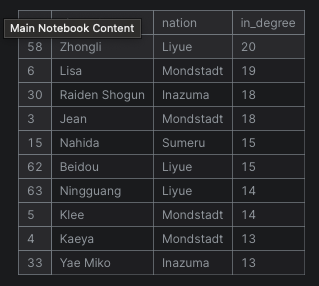|

There has been no changes to the top 10 characters by in-degree centrality - the most mentioned characters remain the same at the top.

### 2.2.2 Out-Degree Centrality

A character is more central (important) to a network if they _know_ a lot of other characters.

A higher out-degree centrality implies that a character is knows more characters in the network.

In [28]:
# add out-degree centrality
summary_df['out_degree'] = summary_df['character'].apply(lambda n: DG.out_degree(n))

In [29]:
# average out-degree
summary_df['out_degree'].mean()

8.372340425531915

Each character knows about 8 other characters.

From version 4.6 where the mean out-degree centrality is 8.194, there has been a slight increase in version 4.7.

(The in-degree and out-degree centralities seem to still, have the same mean value, curious...)

In [30]:
# display top 10 characters with the highest out-degree centrality
summary_df[['character', 'nation', 'out_degree']].sort_values(by='out_degree', ascending=False).head(10)

,character,nation,out_degree
92,Wanderer,Sumeru,15
4,Kaeya,Mondstadt,14
35,Arlecchino,Fontaine,14
6,Lisa,Mondstadt,14
9,Xingqiu,Liyue,14
63,Ningguang,Liyue,14
21,Eula,Mondstadt,13
54,Keqing,Liyue,13
64,Xiangling,Liyue,13
3,Jean,Mondstadt,13


| Top 10 Out-Degree Characters (ver 4.6) |
| : |
|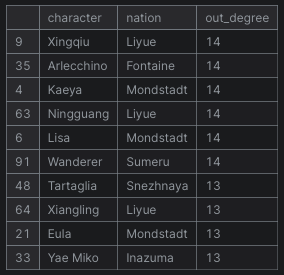|

🆕 Wanderer joins the top 10 for having mentioned others most, a surprise considering his character in-game. This increase is likely due to the addition of new character Sethos. 

### 2.2.3 Page Rank Centrality

Adds an additional consideration for influence — what matters more than the number of characters mentioning a character (in-degree) is how many influential ties are in-coming.

A higher page rank centrality value suggests that a character is connected to more influencial characters and has a wider reach beyond their direct ties.

In [31]:
# add page rank centrality
summary_df['page_rank'] = summary_df['character'].apply(lambda n: nx.pagerank(DG)[n])

In [32]:
# display top 10 characters with the highest page rank centrality
summary_df[['character', 'nation', 'page_rank']].sort_values(by='page_rank', ascending=False).head(10)

,character,nation,page_rank
3,Jean,Mondstadt,0.028670
30,Raiden Shogun,Inazuma,0.026868
6,Lisa,Mondstadt,0.022665
58,Zhongli,Liyue,0.020130
28,Kujou Sara,Inazuma,0.019452
63,Ningguang,Liyue,0.019260
62,Beidou,Liyue,0.018524
11,Cyno,Sumeru,0.018219
42,Lyney,Fontaine,0.017812
64,Xiangling,Liyue,0.017731


| Top 10 Page-Rank Centrality Characters (ver 4.6) |
| : |
|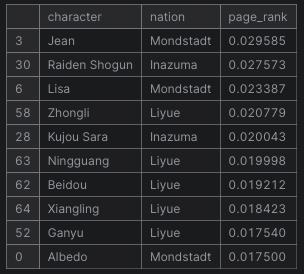|

😵 Dropped out of top 10: Ganyu, Albedo

🔻 Dropped in rank but still in top 10: Xiangling

🆕 New in top 10: Cyno, Lyney

# 3. Undirected Graph

## 3.1. Build Undirected Graph

fom the directed graph  only considering reciprocal ties (both characters are considered to have a tie if the both mention each other).

In [33]:
UG = DG.to_undirected(reciprocal=True)

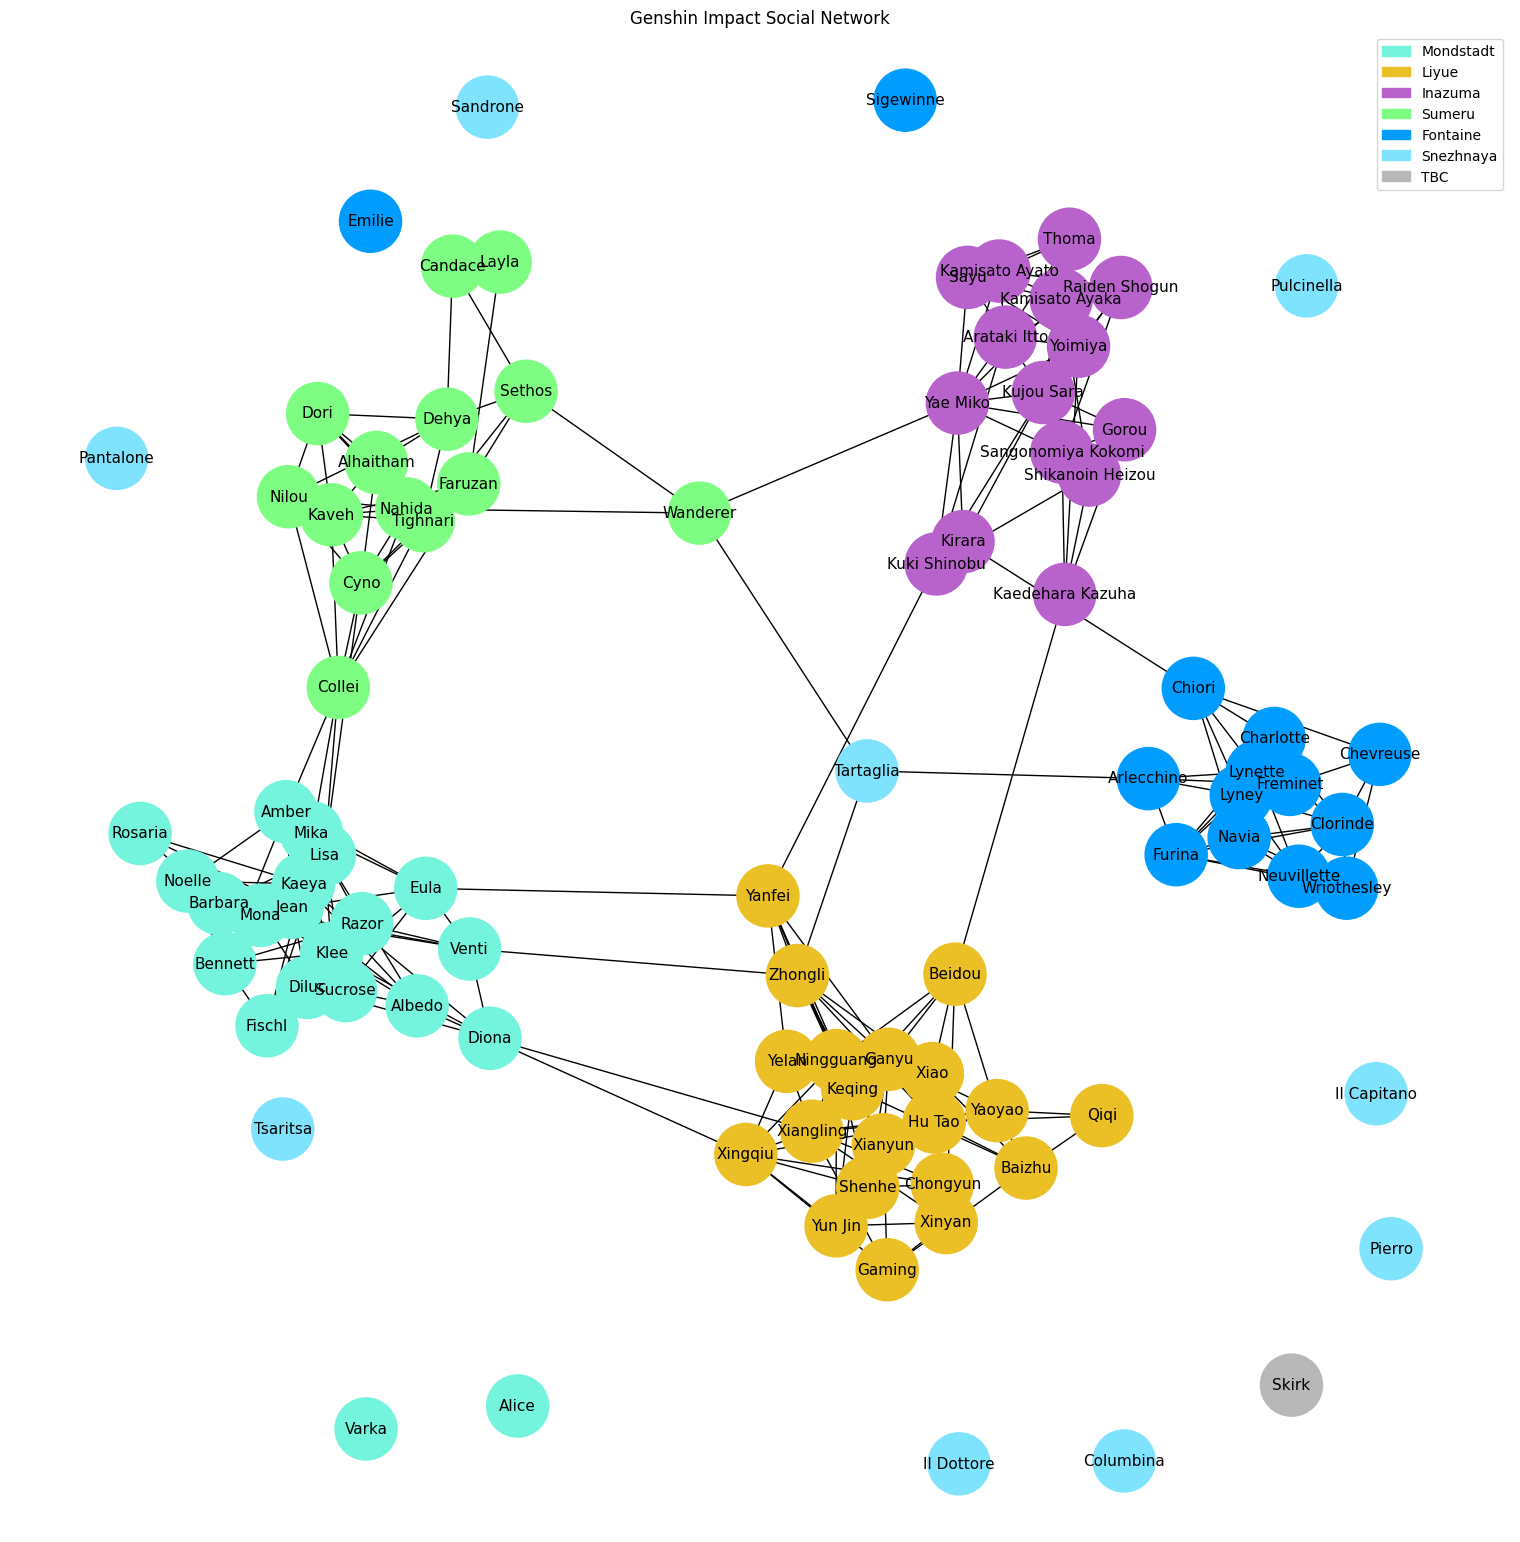

In [34]:
np.random.seed(2000)
pos = nx.spring_layout(UG, k=0.3, iterations=45)

plt.figure(1,figsize=(15,15)) 
nx.draw(UG,
        pos = pos,
        node_size=2000,
        node_color=node_colors,
        with_labels=True,
        font_size = 11,
        font_color='black')

# create legend
legend_tiles = [mpatches.Patch(color=v, label=k) for k, v in NATION_COLOUR_MAPPING.items()]
legend_tiles.append(mpatches.Patch(color="#b8b8b8", label="TBC"))

plt.title("Genshin Impact Social Network")
plt.legend(handles=legend_tiles, loc="upper right")
plt.show()

# uncomment to save picture
# plt.savefig('undirected.png')

<u>Undirected Network Observations</u>

Making the graph undirected and enforcing that ties (edges) be mutual, caused the graph to have isolates (not connected to the rest of the network).

Isolated character are unlikely to be important players in the network (at this point) and will be removed for further analysis.

In [35]:
# remove isolates (characters not connected to any other characters)
UG.remove_nodes_from(list(nx.isolates(UG)))

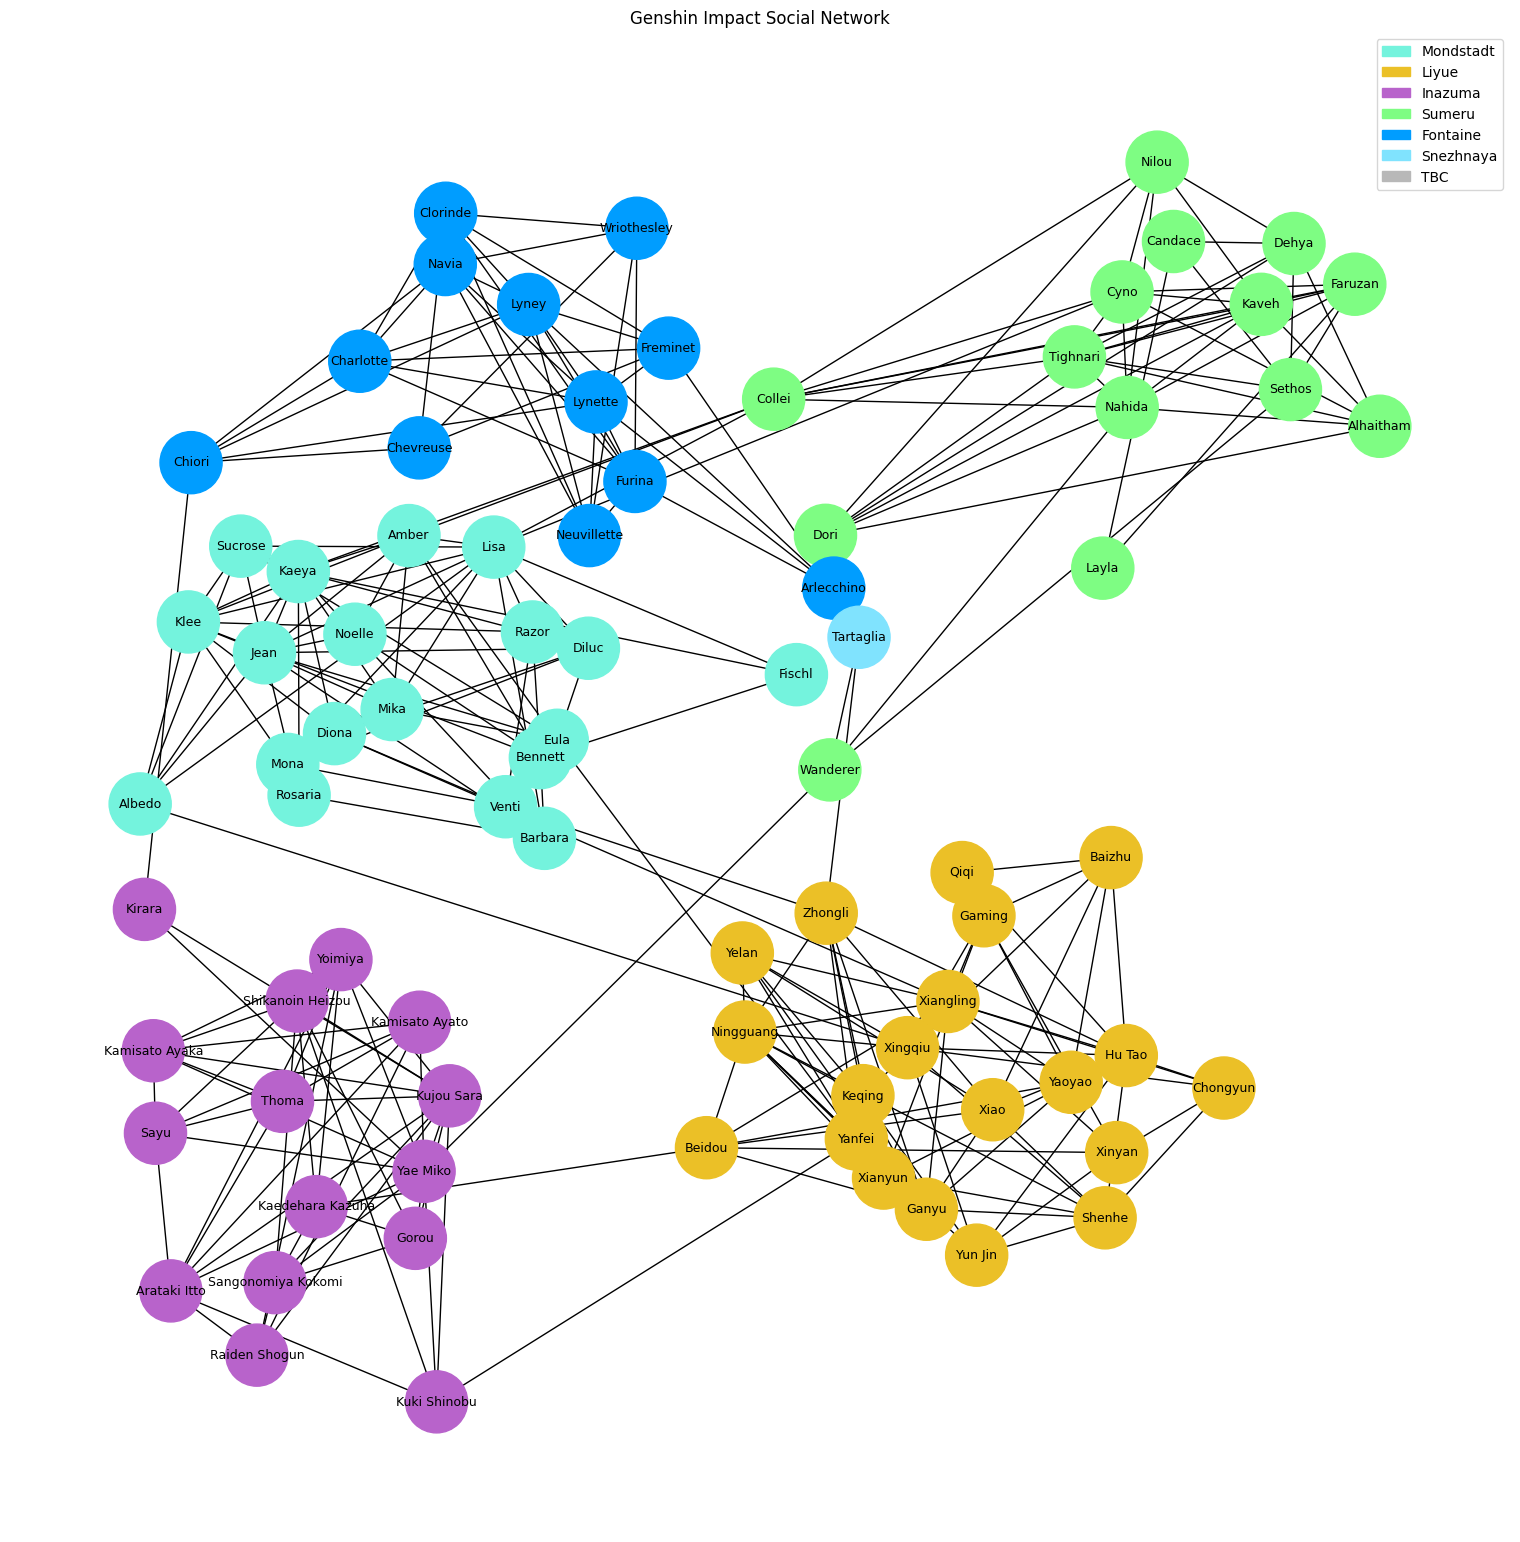

In [36]:
# redo node colours list
node_colors = []
for node, nation in list(UG.nodes(data="nation")):
    if nation in NATION_COLOUR_MAPPING.keys():
        node_colors.append(NATION_COLOUR_MAPPING[nation])
    else:
        node_colors.append('#b8b8b8') # doesn't belong to any nation / not seen yet
        
pos = nx.spring_layout(DG, k=0.5, iterations=40)

plt.figure(1,figsize=(15,15)) 
nx.draw(UG,
        pos = pos,
        node_size=2000,
        node_color=node_colors,
        with_labels=True,
        font_size = 9,
        font_color='black')

# create legend
legend_tiles = [mpatches.Patch(color=v, label=k) for k, v in NATION_COLOUR_MAPPING.items()]
legend_tiles.append(mpatches.Patch(color="#b8b8b8", label="TBC"))

plt.title("Genshin Impact Social Network")
plt.legend(handles=legend_tiles, loc="upper right")
plt.show()

# uncomment to save picture
# plt.savefig('undirected without isolates.png')

### 3.1.1 Minimum Cut Nodes

Which character(s) when removed from the network, causes fractures in the network?

In [37]:
nx.minimum_node_cut(UG)

{'Arlecchino', 'Chiori'}

If Candace and Faruzan are removed from the network, someone will be isolated from the network (it's Layla).

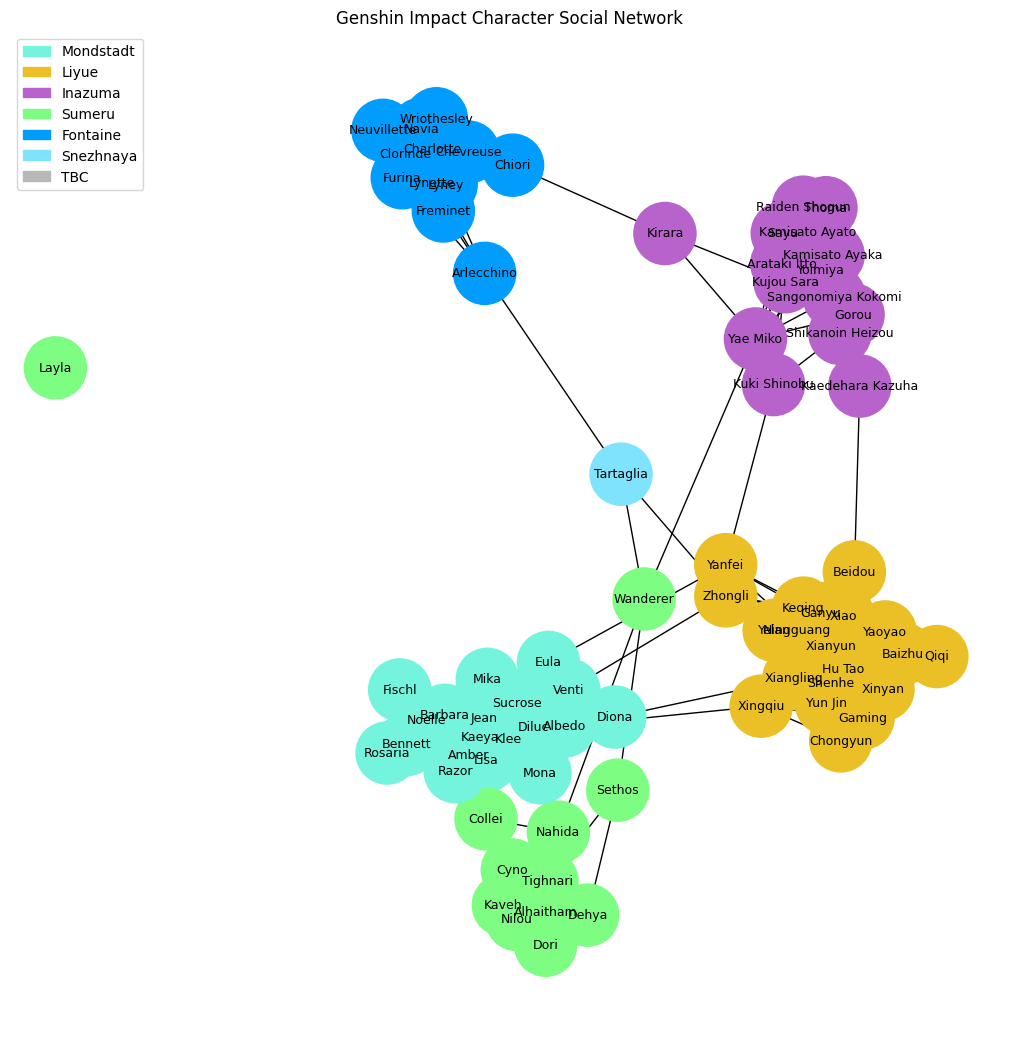

In [38]:
# see a network without Candace and Faruzen
temp_copy = UG.copy()
temp_copy.remove_nodes_from(['Candace', 'Faruzan'])
temp_copy.nodes()

node_colors = []
for node, nation in list(temp_copy.nodes(data="nation")):
    if nation in NATION_COLOUR_MAPPING.keys():
        node_colors.append(NATION_COLOUR_MAPPING[nation])
    else:
        node_colors.append('#b8b8b8') # doesn't belong to any nation / not seen yet
np.random.seed(2021)
pos = nx.spring_layout(temp_copy, k=0.3, iterations=75)

plt.figure(1,figsize=(10,10)) 
nx.draw(temp_copy,
        pos = pos,
        node_size=2000,
        node_color=node_colors,
        with_labels=True,
        font_size = 9,
        font_color='black')

# create legend
legend_tiles = [mpatches.Patch(color=v, label=k) for k, v in NATION_COLOUR_MAPPING.items()]
legend_tiles.append(mpatches.Patch(color="#b8b8b8", label="TBC"))

plt.title("Genshin Impact Character Social Network")
plt.legend(handles=legend_tiles, loc="upper left")
plt.show()

## 3.2 Node Importance Measures

### 3.2.1 Closeness Centrality

Measures the average of the shortest path length of a character to every other character in the network.
 
Closeness centrality can be calculated with a directed graph but just because a character talks about another character doesn't make them able to transmit information if they do not mutually know each other - which is the reason this measure is calculated with the undirected graph.

In [39]:
# add closeness centrality
summary_df['closeness'] = summary_df['character'].apply(lambda n: nx.closeness_centrality(UG)[n] if n in list(UG.nodes) else np.nan)

In [40]:
# display top 10 characters with the highest closeness centrality
summary_df[['character', 'nation', 'closeness']].sort_values(by='closeness', ascending=False).head(10)

,character,nation,closeness
58,Zhongli,Liyue,0.344828
48,Tartaglia,Snezhnaya,0.334728
87,Yanfei,Liyue,0.333333
92,Wanderer,Sumeru,0.327869
63,Ningguang,Liyue,0.313725
52,Ganyu,Liyue,0.311284
29,Kuki Shinobu,Inazuma,0.310078
33,Yae Miko,Inazuma,0.308880
21,Eula,Mondstadt,0.308880
64,Xiangling,Liyue,0.303030


| Top 10 Closeness Centrality Characters (ver 4.6) |
| : |
|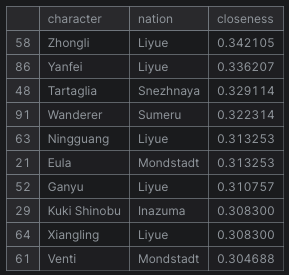|

😵 Dropped out of top 10: Venti

🔻 Dropped in rank but still in top 10: Yanfei, Ganyu, Kuki Shinobu, Xiangling

🔼 Rose in rank in top 10: Tartaglia, Eula

🆕 New in top 10: Yae Miko

### 3.2.2 Betweenness Centrality

Measures the extent in which a character is in the shortest path between other characters.
 
A character with a higher betweenness centrality score has more influence in the network given that they stand between information flow between other characters more often.

In [41]:
# add betweenness centrality
summary_df['betweenness'] = summary_df['character'].apply(lambda n: nx.betweenness_centrality(UG)[n] if n in list(UG.nodes) else np.nan)

In [42]:
# display top 10 characters with the highest betweenness centrality
summary_df[['character', 'nation', 'betweenness']].sort_values(by='betweenness', ascending=False).head(10)

,character,nation,betweenness
48,Tartaglia,Snezhnaya,0.230799
58,Zhongli,Liyue,0.217254
92,Wanderer,Sumeru,0.183175
35,Arlecchino,Fontaine,0.170504
33,Yae Miko,Inazuma,0.141445
87,Yanfei,Liyue,0.137702
15,Nahida,Sumeru,0.108462
29,Kuki Shinobu,Inazuma,0.101487
20,Collei,Sumeru,0.095361
21,Eula,Mondstadt,0.092674


<u>Observations</u>
* Currently playable Fatui characters such as Tartaglia, Wanderer and Arlecchino might have high betweenness centrality values as they are the only characters that bridge the network to any other unreleased Fatui harbringers (see: 2. Directed Graph above)

| Top 10 Closeness Centrality Characters (ver 4.6) |
| : |
|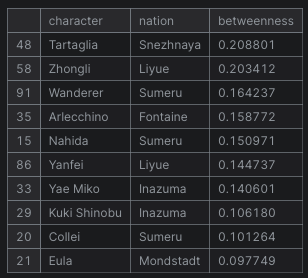|

🔻 Dropped in rank but still in top 10: Nahida

🔼 Rose in rank in top 10: Yae Miko

# 4. Synthesis

Add a ranking for the characters for each measure of centrality (importance). 

In [43]:
# fill NaN with 0
summary_df = summary_df.fillna(0)

In [44]:
# add ranks based on different centrality values

# directed graph measures
summary_df['in_degree_rank'] = summary_df['in_degree'].rank(method='first', ascending=False).astype(int)
summary_df['out_degree_rank'] = summary_df['out_degree'].rank(method='first', ascending=False).astype(int)
summary_df['page_rank_rank'] = summary_df['page_rank'].rank(method='first', ascending=False).astype(int)

# undirected graph measures
summary_df['closeness_rank'] = summary_df['closeness'].rank(method='first', ascending=False).astype(int)
summary_df['betweenness_rank'] = summary_df['betweenness'].rank(method='first', ascending=False).astype(int)

In [45]:
rank_df = summary_df.filter(regex='(character)|(nation)|(_rank$)', axis=1).drop(columns=['page_rank'])   # filter only rank columns

In [46]:
# add average rank column
rank_df['average_rank'] = rank_df.mean(numeric_only=True, axis=1)
rank_df.sort_values('average_rank').style.background_gradient(subset=list(rank_df.columns[2:]), cmap='GnBu')
# rank_df.sort_values('average_rank').style.background_gradient(axis=0, gmap=rank_df['average_rank'], cmap='magma') # uncomment to highlight the entire row based on average_rank value

,character,nation,in_degree_rank,out_degree_rank,page_rank_rank,closeness_rank,betweenness_rank,average_rank
58,Zhongli,Liyue,1,16,4,1,2,4.800000
6,Lisa,Mondstadt,2,3,3,21,12,8.200000
63,Ningguang,Liyue,8,6,6,5,26,10.200000
33,Yae Miko,Inazuma,12,9,23,9,5,11.600000
4,Kaeya,Mondstadt,9,2,15,19,15,12.000000
64,Xiangling,Liyue,15,12,10,11,13,12.200000
3,Jean,Mondstadt,3,7,1,26,36,14.600000
15,Nahida,Sumeru,5,31,20,12,7,15.000000
28,Kujou Sara,Inazuma,11,21,5,18,22,15.400000
52,Ganyu,Liyue,14,14,13,6,31,15.600000


### 4.1 Conclusion

The most important person in the genshin impact network currently is likely to be <mark>Zhongli</mark>, with the highest average rank (lowest value in `average_rank` collumn).

Zhongli is not only at the centre of the network in terms of popularity (highest in-degree centrality), the characters he knows are also of high influence in the network (top 5 in page rank centrality).

Additionally, he is also in a good position in the network to spread information, being the prime character to spread information to the rest of the network (highest in closeness centrality) and also receive information (2nd highest in betweenness centrality).


A notable change since version 4.6 is Yae Miko being 4th in the overall ranks in version 4.7.

## 4.2 Further Analysis

* Adding a hub and authority measures may help to understand which characters are information authorities in the network

## 4.3 Resources

[Social Network Analysis: From Graph Theory to Applications with Python](https://towardsdatascience.com/social-network-analysis-from-theory-to-applications-with-python-d12e9a34c2c7) - basics of social network analysis

[Genshin Network Analysis](https://www.kaggle.com/code/riasingh12/genshin-network-analysis/notebook) - another analysis 

[原神人物网络图 / social network graph of Genshin characters](https://github.com/King-of-Infinite-Space/genshin-social-network?tab=readme-ov-file) - an interactive version of the genshin impact social network